# History Matching iLOVECLIM - Article version
Author: Maya Janvier

Date: 10/07/2023
### Libraries

In [1]:
getwd()

[1] "/mnt/homedafs-2.10/mjanvier/iLOVECLIM_HistoryMatching/Experiments"

In [2]:
mogp_dir <- "/home/mjanvier/.local/lib/python3.9/site-packages" 

setwd('/homedata/mjanvier/iLOVECLIM_HistoryMatching/')

source('ExeterUQ_MOGP/BuildEmulator/BuildEmulator.R')
source('ExeterUQ_MOGP/HistoryMatching/HistoryMatching.R') 
source('ExeterUQ_MOGP/BuildEmulator/utils.R')

library(comprehenr)
library(caret, include.only = 'preProcess')
library("future.apply") #important for parallel version of ImplausibilityMOGP function in HistoryMatching.R
library(stringr)
library(jsonlite)
library(ClusterR)

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


Attaching package: ‘maps’


The following object is masked from ‘package:viridis’:

    unemp


This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORE

In [3]:
future::availableCores() 

system 
    48

### Parameters of the experiment

In [4]:
# TRUTH
bounds_truth <- read_json(path="Experiments/parameters/truth/truth_bounds.json")
params_truth <- read_json(path="Experiments/parameters/truth/truth_params.json")

In [5]:
# default param of the model (ground truth) on [-1,1]
param.def = data.frame(ampwir=c(params_truth$ampwir), expir=c(params_truth$expir), relhmax=c(params_truth$relhmax),
                       alphd=c(params_truth$alphd), ai=c(params_truth$ai), aitd=c(params_truth$aitd),
                       cwdrag=c(params_truth$cwdrag), avkb=c(params_truth$avkb), cgren=c(params_truth$cgren))

my_bounds <- data.frame(c(bounds_truth$ampwir[[1]], bounds_truth$ampwir[[2]]),
                        c(bounds_truth$expir[[1]], bounds_truth$expir[[2]]),
                        c(bounds_truth$relhmax[[1]], bounds_truth$relhmax[[2]]),
                        c(bounds_truth$alphd[[1]], bounds_truth$alphd[[2]]),
                        c(bounds_truth$ai[[1]], bounds_truth$ai[[2]]),
                        c(bounds_truth$aitd[[1]], bounds_truth$aitd[[2]]),
                        c(bounds_truth$cwdrag[[1]], bounds_truth$cwdrag[[2]]),
                        c(bounds_truth$avkb[[1]], bounds_truth$avkb[[2]]),
                        c(bounds_truth$cgren[[1]], bounds_truth$cgren[[2]])) 

param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1)) #normalized 
print(param.defaults.norm)

  ampwir        expir relhmax alphd    ai  aitd     cwdrag       avkb
1      0 2.220446e-16    0.65  -0.2 -0.75 -0.75 -0.2666667 -0.8888889
       cgren
1 -0.3333333


# Get parameters of the experiment
You can try 3 experiments:
- ATM_MEAN5
- ATM-EVO_MEAN20
- ATM-EVO_MEAN100
- ATM-EVO_MEAN100-20
- ATM-EVO_MV100

In [6]:
choose_exp = "ATM-EVO_MEAN20"

In [7]:
# EXPERIMENT 
simu_param <- read_json(path=str_glue("Experiments/parameters/simulations/{choose_exp}_params.json"))
NAME_START = simu_param$NAME_START
NAME_EXP = simu_param$NAME_EXP
simu_param

$NB_YEAR_SIMU
[1] 20

$NB_YEAR_TRUTH
[1] 20

$NAME_START
[1] "SHI_START"

$NAME_EXP
[1] "ATM-EVO_MEAN_20L"

$WAVE_K_MEANS
[1] 1

$WAVE_CANDIDATE
[1] 2

$OPT_CLUSTERS
[1] 7

In [8]:
N_PARAM = size(params_truth)[[2]]
EXP = NAME_EXP

#  Wave 1
## Step 1: LHS for simulation points

In [9]:
# first LHS 
set.seed(42) # seed for reproducibility
inputs <- as.data.frame(2*maximinLHS(N_PARAM*10, N_PARAM)-1)
inputs_unscaled <- rangeUnscale(inputs, my_bounds)
names(inputs) <- c('ampwir', 'expir', 'relhmax', 'alphd', 'ai', 'aitd', 'cwdrag', 'avkb', 'cgren')
names(inputs_unscaled) <- c('ampwir', 'expir', 'relhmax', 'alphd', 'ai', 'aitd', 'cwdrag', 'avkb', 'cgren')
inputs_unscaled

ampwir    expir     relhmax   alphd     ai       aitd     cwdrag     
1  0.9854780 0.4390126 0.6912458 0.7201578 540.5000 555.1697 0.001869904
2  1.1893264 0.3192290 0.7435344 0.7009016 751.1601 520.3708 0.003070775
3  1.0337519 0.3977748 0.6965722 0.7550437 704.1900 593.9713 0.002369798
4  1.0006296 0.3693046 0.7168114 0.7381049 612.4715 676.6957 0.003717662
5  0.9249279 0.5831087 0.6434333 0.6401755 680.8464 452.3048 0.001825807
6  0.8531708 0.3829179 0.6284427 0.8536558 747.5567 510.7307 0.002824795
7  1.1771605 0.3255461 0.6400803 0.7839547 448.8114 580.1984 0.002661909
8  1.0156785 0.5548966 0.6678839 0.7420608 649.7274 825.2102 0.003035521
9  1.1024133 0.4507783 0.8082017 0.7469137 810.0278 650.4577 0.002566230
10 0.6343377 0.2818106 0.5975776 0.7705214 429.5250 540.9014 0.003543908
11 1.0630817 0.5005625 0.6226960 0.6769702 484.5828 435.4948 0.001753040
12 1.1414339 0.4336328 0.5481184 0.7688692 320.6611 807.7368 0.002189204
13 1.2398805 0.4229330 0.7301811 0.7740358 281.3540 569.4419 0.002441532
14 0.8419798 0.3070043 0.8386408 0.8910319 300.7219 803.7925 0.002608707
15 0.9354046 0.3289261 0.6537364 0.8233936 346.7285 893.6876 0.002251785
16 0.9144828 0.4438440 0.5620532 0.6868051 941.0547 712.6228 0.003368132
17 0.8022176 0.3457965 0.6565299 0.6136087 477.0354 722.1126 0.001633918
18 0.7946128 0.5099886 0.8784744 0.6856667 730.9035 816.0283 0.001537826
19 0.8306564 0.4062932 0.8248410 0.8195317 837.7137 936.9748 0.002276801
20 0.7099188 0.5629618 0.6188556 0.7098927 519.2746 429.2296 0.003883517
21 0.5882331 0.4275624 0.7049100 0.6603158 405.5521 459.0455 0.002035568
22 0.8950689 0.4763317 0.6784709 0.7987688 534.0544 393.8933 0.003603976
23 1.3223575 0.3875136 0.6824376 0.7922202 770.4198 637.3312 0.002315053
24 1.3723042 0.5503242 0.7839544 0.8097552 465.0407 344.8806 0.002008554
25 0.9509173 0.3505482 0.7024647 0.6599626 783.7005 501.6060 0.002365877
26 0.6535349 0.4916512 0.5909595 0.6439513 261.9158 301.3574 0.002597459
27 1.4280119 0.4001869 0.6290539 0.6095838 495.9344 517.7668 0.001860098
28 0.5174537 0.3654296 0.8881541 0.6638773 473.6306 381.3889 0.003583528
29 1.2965385 0.3621295 0.7581727 0.6811235 639.9841 972.3463 0.002710236
30 1.4000508 0.3940217 0.8232711 0.8658784 372.3435 955.1229 0.003240257
⋮  ⋮         ⋮         ⋮         ⋮         ⋮        ⋮        ⋮          
61 0.6105580 0.2734648 0.7339402 0.8106378 554.1258 446.9736 0.001327001
62 1.3805842 0.4829364 0.5489986 0.7584526 883.4894 253.9675 0.003140402
63 0.9064581 0.3222747 0.6904984 0.8957424 242.2235 665.9386 0.003905713
64 1.3451669 0.5037001 0.8168574 0.7955748 331.8864 620.2839 0.002978897
65 1.0934270 0.4630137 0.7861638 0.6229201 449.6638 334.9116 0.002900115
66 0.7524622 0.5912988 0.5131457 0.8825677 723.0479 295.9937 0.001504470
67 0.5558842 0.5574165 0.5054921 0.8603713 527.5301 885.0797 0.003282963
68 1.2877171 0.2203688 0.8709968 0.7512332 958.2410 405.5899 0.003999816
69 0.9747873 0.4675826 0.7630738 0.7152478 995.1986 740.4516 0.003747699
70 0.5442515 0.4196400 0.7236288 0.8500781 904.9504 855.2361 0.002125748
71 0.7335713 0.5159076 0.7751491 0.6482836 735.0414 320.9753 0.003777611
72 1.1264718 0.2083107 0.5655677 0.8401312 421.1728 631.0064 0.002205484
73 1.4808990 0.4564991 0.5723734 0.6369011 693.0329 987.0204 0.001163571
74 1.2522075 0.5344757 0.5853487 0.6963993 294.7306 764.5719 0.003507323
75 1.2756118 0.4598456 0.7482310 0.8394087 970.3568 870.8277 0.001923165
76 0.5536724 0.2916746 0.7952887 0.6913876 394.5487 662.1105 0.003689017
77 1.2572567 0.5994765 0.8318262 0.7038053 866.5136 784.1994 0.001415145
78 0.7757518 0.5135722 0.6072293 0.6277388 622.0857 328.3448 0.001043558
79 0.5729803 0.2145383 0.7756526 0.7237170 801.2329 908.0763 0.001083019
80 0.7308517 0.3756173 0.8749934 0.8153366 572.7031 203.9584 0.002668282
81 1.4947344 0.2706813 0.7910281 0.6995375 355.1629 861.4397 0.003199298
82 0.8776104 0.4149062 0.6767404 0.6103134 244.7961 916.6366 0.003801094
83 0.5306519 0.2034009 0.6005067 0.8975848 869.5017 981.0530 

In [10]:
write.csv(inputs_unscaled,str_glue("DATA/{EXP}/df_inputs_newPCA_wave1.csv"), row.names = FALSE)

## _Step 2: Please move to the Python notebook, run iLOVECLIM and get metrics, then come back_

* Observations discrepancy variances in *tDisc* (here sets to 0)
* Observations errors in *tObsErr* (here set to 0)

In [11]:
# delete failed simulations from inputs
delete_fails <- function(nb_wave,data){
    if (file.exists(str_glue("DATA/{EXP}/fails_wave{nb_wave}.csv"))){
        fails <- read.csv(str_glue("DATA/{EXP}/fails_wave{nb_wave}.csv"))
        fails <- as.list(fails)$X0
        print(fails)
        data <- data[-c(fails),]
    }
    else{print("No fails")}
    data
}

In [12]:
inputs <- delete_fails(1,inputs)
inputs_unscaled <- delete_fails(1, inputs_unscaled)
inputs_unscaled

[1] "No fails"
[1] "No fails"


ampwir    expir     relhmax   alphd     ai       aitd     cwdrag     
1  0.9854780 0.4390126 0.6912458 0.7201578 540.5000 555.1697 0.001869904
2  1.1893264 0.3192290 0.7435344 0.7009016 751.1601 520.3708 0.003070775
3  1.0337519 0.3977748 0.6965722 0.7550437 704.1900 593.9713 0.002369798
4  1.0006296 0.3693046 0.7168114 0.7381049 612.4715 676.6957 0.003717662
5  0.9249279 0.5831087 0.6434333 0.6401755 680.8464 452.3048 0.001825807
6  0.8531708 0.3829179 0.6284427 0.8536558 747.5567 510.7307 0.002824795
7  1.1771605 0.3255461 0.6400803 0.7839547 448.8114 580.1984 0.002661909
8  1.0156785 0.5548966 0.6678839 0.7420608 649.7274 825.2102 0.003035521
9  1.1024133 0.4507783 0.8082017 0.7469137 810.0278 650.4577 0.002566230
10 0.6343377 0.2818106 0.5975776 0.7705214 429.5250 540.9014 0.003543908
11 1.0630817 0.5005625 0.6226960 0.6769702 484.5828 435.4948 0.001753040
12 1.1414339 0.4336328 0.5481184 0.7688692 320.6611 807.7368 0.002189204
13 1.2398805 0.4229330 0.7301811 0.7740358 281.3540 569.4419 0.002441532
14 0.8419798 0.3070043 0.8386408 0.8910319 300.7219 803.7925 0.002608707
15 0.9354046 0.3289261 0.6537364 0.8233936 346.7285 893.6876 0.002251785
16 0.9144828 0.4438440 0.5620532 0.6868051 941.0547 712.6228 0.003368132
17 0.8022176 0.3457965 0.6565299 0.6136087 477.0354 722.1126 0.001633918
18 0.7946128 0.5099886 0.8784744 0.6856667 730.9035 816.0283 0.001537826
19 0.8306564 0.4062932 0.8248410 0.8195317 837.7137 936.9748 0.002276801
20 0.7099188 0.5629618 0.6188556 0.7098927 519.2746 429.2296 0.003883517
21 0.5882331 0.4275624 0.7049100 0.6603158 405.5521 459.0455 0.002035568
22 0.8950689 0.4763317 0.6784709 0.7987688 534.0544 393.8933 0.003603976
23 1.3223575 0.3875136 0.6824376 0.7922202 770.4198 637.3312 0.002315053
24 1.3723042 0.5503242 0.7839544 0.8097552 465.0407 344.8806 0.002008554
25 0.9509173 0.3505482 0.7024647 0.6599626 783.7005 501.6060 0.002365877
26 0.6535349 0.4916512 0.5909595 0.6439513 261.9158 301.3574 0.002597459
27 1.4280119 0.4001869 0.6290539 0.6095838 495.9344 517.7668 0.001860098
28 0.5174537 0.3654296 0.8881541 0.6638773 473.6306 381.3889 0.003583528
29 1.2965385 0.3621295 0.7581727 0.6811235 639.9841 972.3463 0.002710236
30 1.4000508 0.3940217 0.8232711 0.8658784 372.3435 955.1229 0.003240257
⋮  ⋮         ⋮         ⋮         ⋮         ⋮        ⋮        ⋮          
61 0.6105580 0.2734648 0.7339402 0.8106378 554.1258 446.9736 0.001327001
62 1.3805842 0.4829364 0.5489986 0.7584526 883.4894 253.9675 0.003140402
63 0.9064581 0.3222747 0.6904984 0.8957424 242.2235 665.9386 0.003905713
64 1.3451669 0.5037001 0.8168574 0.7955748 331.8864 620.2839 0.002978897
65 1.0934270 0.4630137 0.7861638 0.6229201 449.6638 334.9116 0.002900115
66 0.7524622 0.5912988 0.5131457 0.8825677 723.0479 295.9937 0.001504470
67 0.5558842 0.5574165 0.5054921 0.8603713 527.5301 885.0797 0.003282963
68 1.2877171 0.2203688 0.8709968 0.7512332 958.2410 405.5899 0.003999816
69 0.9747873 0.4675826 0.7630738 0.7152478 995.1986 740.4516 0.003747699
70 0.5442515 0.4196400 0.7236288 0.8500781 904.9504 855.2361 0.002125748
71 0.7335713 0.5159076 0.7751491 0.6482836 735.0414 320.9753 0.003777611
72 1.1264718 0.2083107 0.5655677 0.8401312 421.1728 631.0064 0.002205484
73 1.4808990 0.4564991 0.5723734 0.6369011 693.0329 987.0204 0.001163571
74 1.2522075 0.5344757 0.5853487 0.6963993 294.7306 764.5719 0.003507323
75 1.2756118 0.4598456 0.7482310 0.8394087 970.3568 870.8277 0.001923165
76 0.5536724 0.2916746 0.7952887 0.6913876 394.5487 662.1105 0.003689017
77 1.2572567 0.5994765 0.8318262 0.7038053 866.5136 784.1994 0.001415145
78 0.7757518 0.5135722 0.6072293 0.6277388 622.0857 328.3448 0.001043558
79 0.5729803 0.2145383 0.7756526 0.7237170 801.2329 908.0763 0.001083019
80 0.7308517 0.3756173 0.8749934 0.8153366 572.7031 203.9584 0.002668282
81 1.4947344 0.2706813 0.7910281 0.6995375 355.1629 861.4397 0.003199298
82 0.8776104 0.4149062 0.6767404 0.6103134 244.7961 916.6366 0.003801094
83 0.5306519 0.2034009 0.6005067 0.8975848 869.5017 981.0530 

In [13]:
Nb_sim_list <- list(nrow(inputs))
Nb_sim_list 

[[1]]
[1] 90

In [14]:
set.seed(42)                   
#Load outputs and observations
outputs <- read.csv(str_glue("DATA/{EXP}/df_metrics_newPCA_wave1.csv"))
tObs <- read.csv(str_glue("DATA/{EXP}/df_obs_nonoise_newPCA_wave1.csv"))
tObs <- as.vector(t(tObs))

In [15]:
# Errors: here perfect model configuration
tDisc <- rep(0, length(outputs)) # tDisc: discrepancy error, intrinsic error of the model
tObsErr <- rep(0, length(outputs)) # Obs=metric here 

In [16]:
add_noise <- function(input, output){
    N = nrow(input)
    noise <- rnorm(N, 0, 0.5)
    tdata <- cbind(input, noise, output)
    names(tdata)[names(tdata) == "noise"] <- "Noise"
    tdata
}

In [17]:
tData = add_noise(inputs, outputs)
head(tData)

ampwir       expir       relhmax     alphd       ai          aitd       
1 -0.029044078  0.19506279 -0.04377120 -0.19894825 -0.14874998 -0.11207567
2  0.378652814 -0.40385496  0.21767200 -0.32732264  0.37790031 -0.19907291
3  0.067503715 -0.01112604 -0.01713900  0.03362496  0.26047492 -0.01507181
4  0.001259235 -0.15347689  0.08405702 -0.07930077  0.03117872  0.19173935
5 -0.150144293  0.91554348 -0.28283348 -0.73216356  0.20211597 -0.36923792
6 -0.293658422 -0.08541052 -0.35778647  0.69103897  0.36889176 -0.22317332
  cwdrag      avkb       cgren        Noise       ⋯ pca_1      pca_2     
1 -0.42006412 -0.1366840 -0.066154944  0.68547922 ⋯  1.4364552  0.1144711
2  0.38051700  0.2905019  0.181433758 -0.28234909 ⋯ -0.4592968  0.6495815
3 -0.08680112 -0.3051356 -0.003806811  0.18156421 ⋯  1.3206670 -0.4079681
4  0.81177496  0.2813720  0.074798032  0.31643130 ⋯ -0.4728688  0.2618431
5 -0.44946217 -0.3369183 -0.022736228  0.20213416 ⋯  2.9844780  1.3426713
6  0.21652980  0.6748764  0.646311641 -0.05306226 ⋯ -0.1797964 -0.6275548
  pca_3      pca_4       pca_5      pca_6        pca_7       pca_8     
1 -1.0415029 -0.22570939 -0.3485611 -0.228202437  0.07632862 -0.6384740
2  1.1422319 -0.34901805 -0.4384305 -0.006766961 -0.38209033 -0.2136185
3 -0.4190744 -0.07928303 -0.8740394 -0.257472886  0.29028817 -0.4899787
4  1.3483859 -0.34316975 -0.2763550 -0.190774883  0.59187854  0.0609297
5 -0.6365931  0.29359530 -0.3454300 -0.103423136 -0.17343675 -0.6627860
6  0.4446843 -1.71516029  0.1257159  0.723804542  0.29925449  0.1665161
  pca_9       pca_10    
1  0.05920333 0.20183223
2 -0.08882957 0.16989588
3 -0.06456933 0.23402191
4  0.08188080 0.04230207
5  0.10180530 0.29100098
6 -0.30867746 0.21458858

## Step 3: Training Emulators

In [18]:
train_emulators <- function(data, output){
    TestEm <- BuildNewEmulators(data,
                            HowManyEmulators = length(output),
                            meanFun = "fitted",
                            additionalVariables = names(data)[1:N_PARAM])  # select parameters data
    TestEm
}

In [19]:
TestEm <- train_emulators(tData, outputs)

[1] "Max reduction is 1.55144606848666 using relhmax"
[1] "Max reduction is 0.543542083705434 using expir"
[1] "Max reduction is 0.324047972407177 using ampwir"
[1] "Max reduction is 0.305282745867024 using alphd"
[1] "Max reduction is 0.0252096352182543 using cgren"
[1] "Max reduction is 0.0184550994898436 using expir"
[1] "Max reduction is 0.182388169126519 using Three Way Interactions with expir"
[1] "Max reduction is 0.082885394971447 using avkb"
[1] "Max reduction is 0.0627843432257597 using cwdrag"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = pca_0 ~ relhmax + expir + I(expir^2) + ampwir + 
    alphd + cgren + avkb + cwdrag + I(expir * relhmax) + I(ampwir * 
    relhmax) + I(alphd * relhmax) + I(cgren * relhmax) + I(avkb * 
    relhmax) + I(cwdrag * relhmax) + I(ampwir * expir) + I(alphd * 
    expir) + I(cgren * expir) + I(avkb * expir) + I(cwdrag * 
    expir) + I(alphd * ampwir) + I(cgren * ampwir) + I(avkb * 
    ampwir) + I(cwdrag * 

### Leave-One-Out (LOO)

In [20]:
LOO <- function(data, obs, emulator){
    cands <- names(data)[1:N_PARAM]
    tLOOs <- LOO.plot(Emulators = emulator, which.emulator = 1, ParamNames = cands, Obs = obs[1], ObsErr = 0.)
    tLOOs <- LOO.plot(Emulators = emulator, which.emulator = 2, ParamNames = cands, Obs = obs[2], ObsErr = 0.)
    tLOOs <- LOO.plot(Emulators = emulator, which.emulator = 3, ParamNames = cands, Obs = obs[3], ObsErr = 0.)
    tLOOs <- LOO.plot(Emulators = emulator, which.emulator = 4, ParamNames = cands, Obs = obs[4], ObsErr = 0.)
    tLOOs <- LOO.plot(Emulators = emulator, which.emulator = 5, ParamNames = cands, Obs = obs[5], ObsErr = 0.)   
}

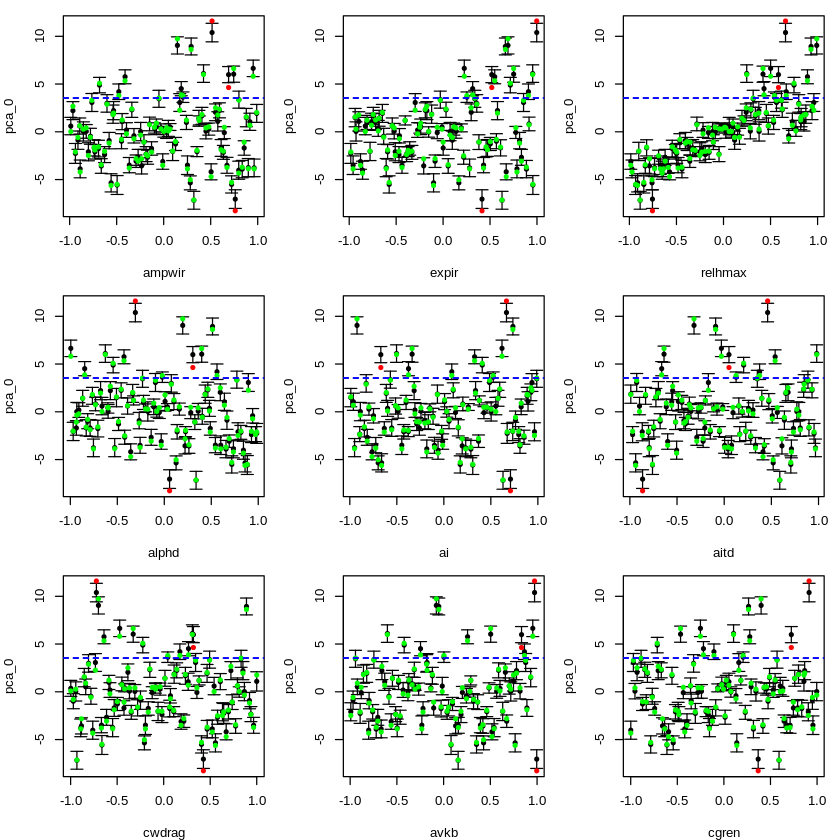

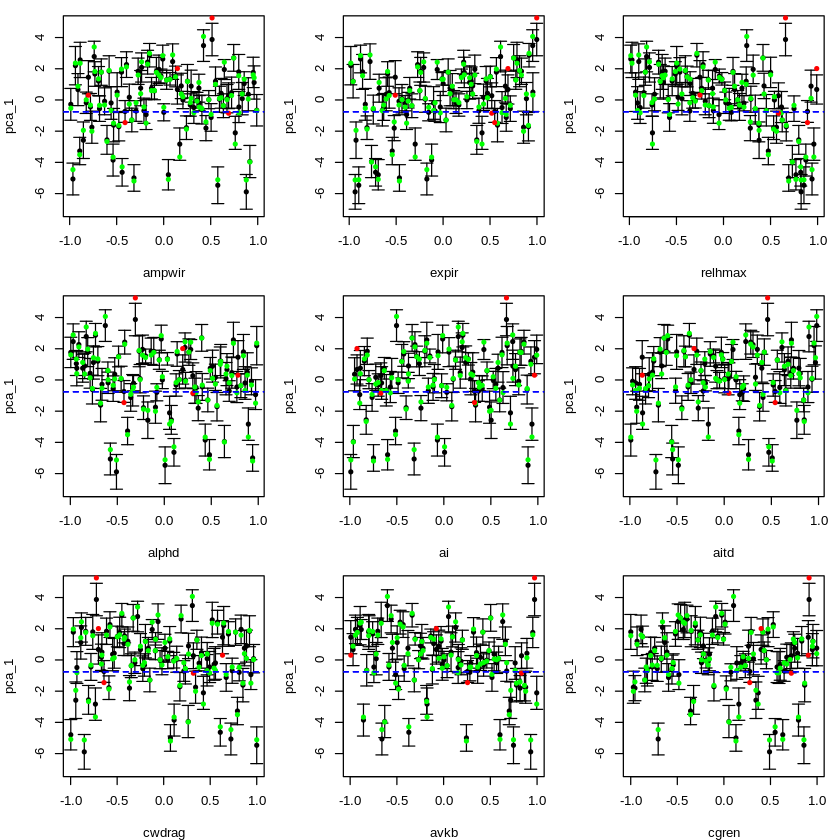

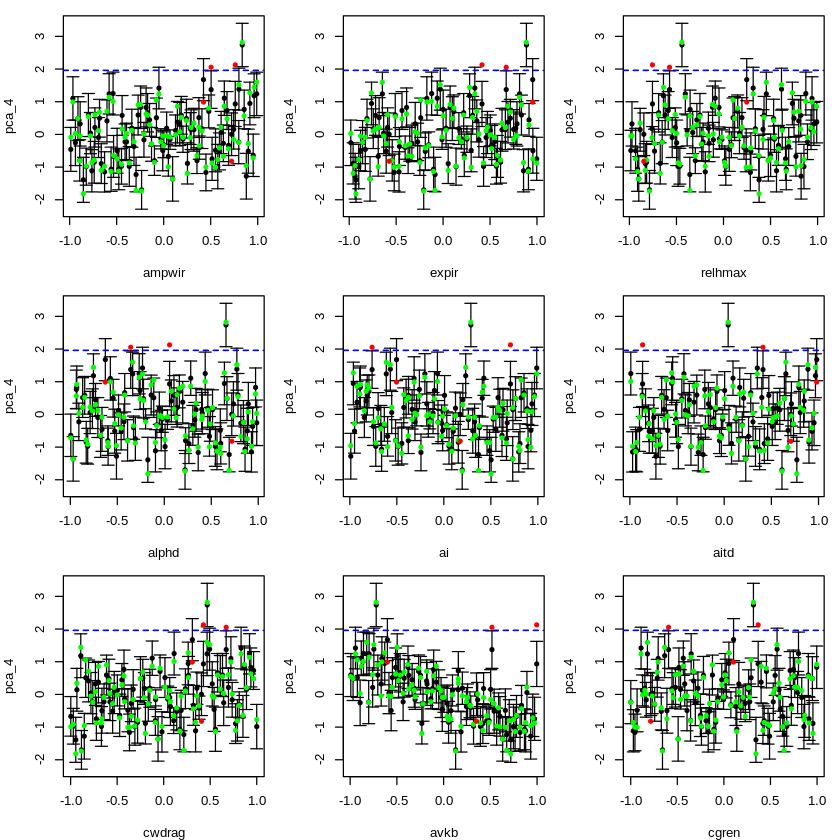

In [21]:
LOO(tData, tObs, TestEm)

## Step 4: implausibility and NROY 
#### N_PARAM $*$ 10 samples for training, 1 000 000 points for test

In [22]:
ratio <- function(nroy){
    ratio <- length(nroy)/dim(Xp)[1]
    ratio
}

compute_Imp <- function(emulator, points){
    timps <- ImplausibilityMOGP(NewData=points, Emulator=emulator,
                                            Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
    timps  
}

compute_ImpListM <- function(timps, emulator, valmax=0){
    ImpData_wave = cbind(Xp, timps)
    implistm = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave,
                             nEms=emulator$mogp$n_emulators, whichMax=valmax+1)
    implistm
}

compute_NROY <- function(timps, emulator, valmax=0){
    nroy <- which(rowSums(timps <= cutoff_vec[1]) >= emulator$mogp$n_emulators -valmax)
    nroy
}

plot_NROY <- function(nroy, implistm){
    imp.layoutm11(implistm,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
    mtext(paste("Remaining space:",length(nroy)/dim(Xp)[1],sep=""), side=1)
}

In [23]:
set.seed(42)
sample_size <- 1000000
nparam <- length(names(TestEm$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1) 
names(Xp) <- names(TestEm$fitting.elements$Design)
VarNames <- names(Xp)

cutoff_vec = 3
valmax = 0

In [24]:
# compute NROY
tImps <-compute_Imp(TestEm, Xp)
ImpListM <- compute_ImpListM(tImps, TestEm)
NROY1 <- compute_NROY(tImps, TestEm)
nroy_list <- list(NROY1)

In [26]:
ratio1 <- ratio(NROY1)
ratio1
ratio_list <- list(ratio1)

[1] 0.000307

In [27]:
plot_NROY(NROY1, ImpListM)

In [28]:
N_PARAM*10/ratio1

[1] 293159.6

# Waves > 1: pipeline

In [81]:
# only for wave > 1
design_points <- function(list_emulators, ratio, method){
    d_points <- data.frame()
    while (nrow(d_points) <= N_PARAM*10) {
        ### for all waves
        Em <- TestEm 
        tmp <- as.data.frame(2*method(ceil(N_PARAM*10/ratio), N_PARAM)-1)
        names(tmp) <- names(Em$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=Em, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= Em$mogp$n_emulators -valmax)
        
        ### iterate for wave > 2 
        for (emul in list_emulators){ 
            Em <- emul 
            tmp <- tmp[NROYtmp,]
            imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=Em, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
            NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= Em$mogp$n_emulators -valmax)
        }

        ### end 
        selectionP <- tmp[NROYtmp,]
        row.names(selectionP) <- NULL
        d_points <- rbind(d_points,selectionP)
        print(nrow(d_points))
        flush.console()
            
    }
    d_points <- d_points[sample(nrow(d_points), N_PARAM*10),]
    d_points
}

compute_Imp_next_wave <- function(timps, nroy, emulator){
    timps_next <- matrix(rep(t(timps),1), ncol=ncol(timps), byrow=TRUE)
    timps_next[nroy,] <- ImplausibilityMOGP(NewData=Xp[nroy,], Emulator=emulator,
                                                     Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
    timps_next
}

wave_step_1 <- function(nb_wave, list_emulators_after1, last_ratio, methodLHS){
    # gives design points 
    set.seed(42)
    design_points <- design_points(list_emulators_after1, last_ratio, methodLHS)
    design_points_denorm <- rangeUnscale(design_points, my_bounds)
    write.csv(design_points_denorm, str_glue("DATA/{EXP}/exp_TuningL94_newPCA_wave{nb_wave}.csv"), row.names = FALSE)
    design_points 
}

# Wave 2

In [82]:
# step 1
Design_points <- wave_step_1(2,list(),ratio1,randomLHS) # no new emulator except the first one TestEm

[1] 89
[1] 165


**_Go to Python notebook for step 2_**

In [83]:
# steps 3 and 4
wave_steps_3_4 <- function(nb_wave, d_point, emulators_list, last_timps, last_nroy ){
    set.seed(42)
    input <- d_point
    
    # delete fails 
    input <- delete_fails(nb_wave,input)

    #Load outputs
    output <- read.csv(str_glue("DATA/{EXP}/df_metrics_newPCA_wave{nb_wave}.csv"))
    t_data <- add_noise(input, output)
    head(t_data)
    
    Nb_sim_list <- append(Nb_sim_list, nrow(input))
    
    # train emulators
    em_wave <- train_emulators(t_data, output)
    LOO(t_data, tObs, em_wave)
    
    # implausibility and NROY
    tImps_wave <- compute_Imp_next_wave(last_timps, last_nroy, em_wave)
    Imp_List_M <- compute_ImpListM(tImps_wave, em_wave)
    NROY_wave <- compute_NROY(tImps_wave, em_wave)
    
    res <- list(impW=Imp_List_M, nroyW = NROY_wave,timpsW=tImps_wave, emulatorW=em_wave )
    res

}

[1] "No fails"
[1] "Max reduction is 0.117651862761665 using expir"
[1] "Max reduction is 0.205752209755096 using ampwir"
[1] "Max reduction is 0.15858307890776 using relhmax"
[1] "Max reduction is 0.157975172661288 using alphd"
[1] "Max reduction is 0.063752927885146 using cgren"
[1] "Max reduction is 0.0389059181113451 using aitd"
[1] "Max reduction is 0.0213187824081974 using avkb"
[1] "Max reduction is 0.0400798605370157 using cwdrag"
[1] "Max reduction is 0.0657368768210297 using ai"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = pca_0 ~ expir + ampwir + relhmax + alphd + cgren + 
    aitd + avkb + cwdrag + ai + I(ampwir * expir) + I(relhmax * 
    expir) + I(alphd * expir) + I(cgren * expir) + I(aitd * expir) + 
    I(avkb * expir) + I(cwdrag * expir) + I(ai * expir) + I(relhmax * 
    ampwir) + I(alphd * ampwir) + I(cgren * ampwir) + I(aitd * 
    ampwir) + I(avkb * ampwir) + I(cwdrag * ampwir) + I(ai * 
    ampwir) + I(alphd * relhmax) + 

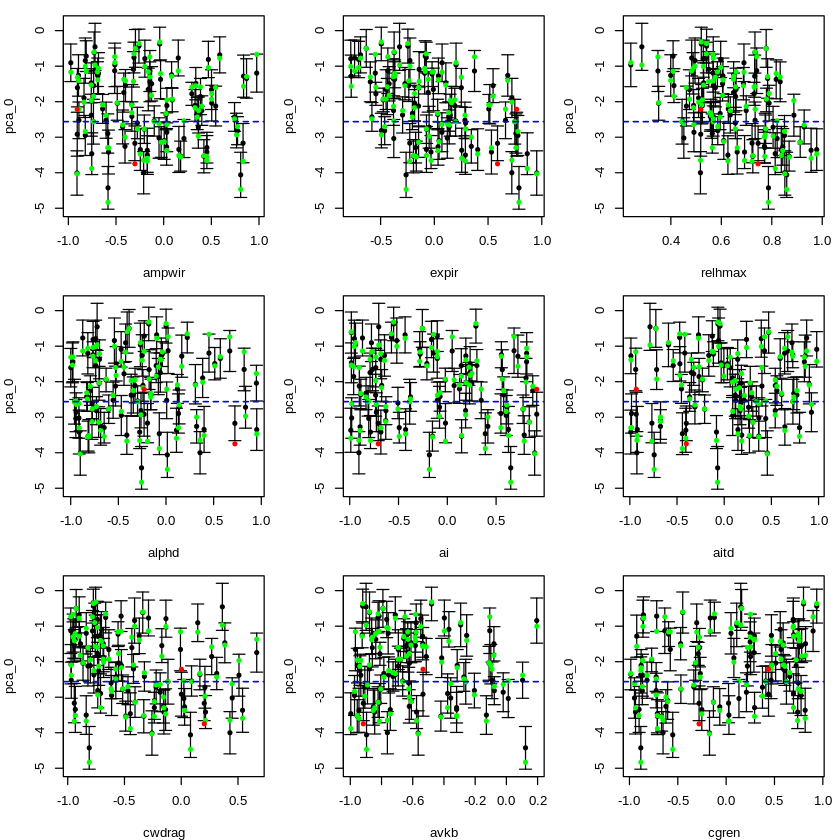

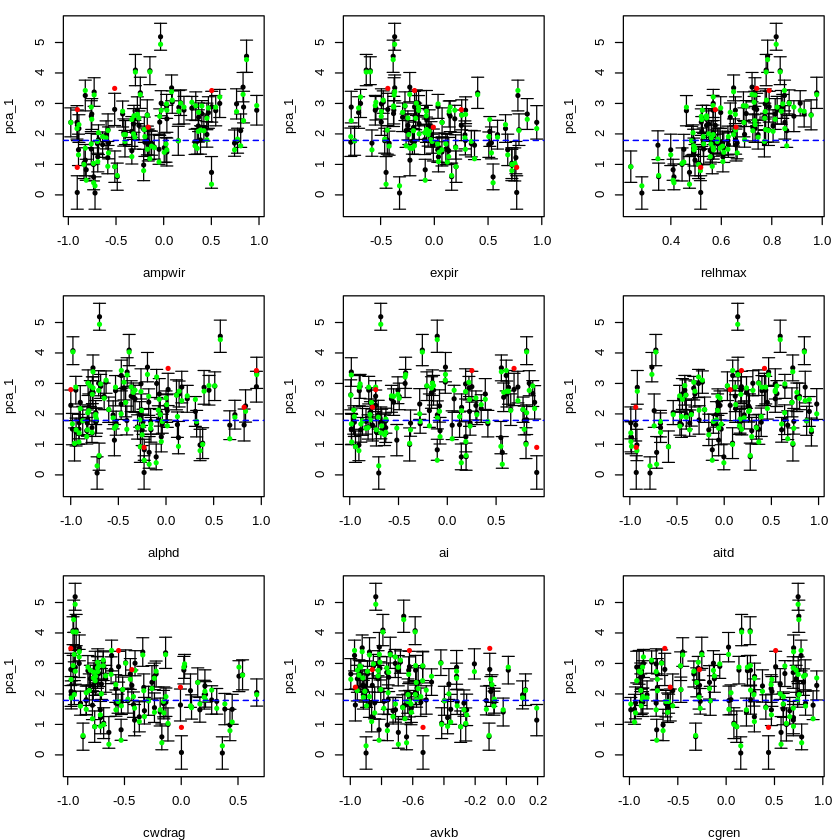

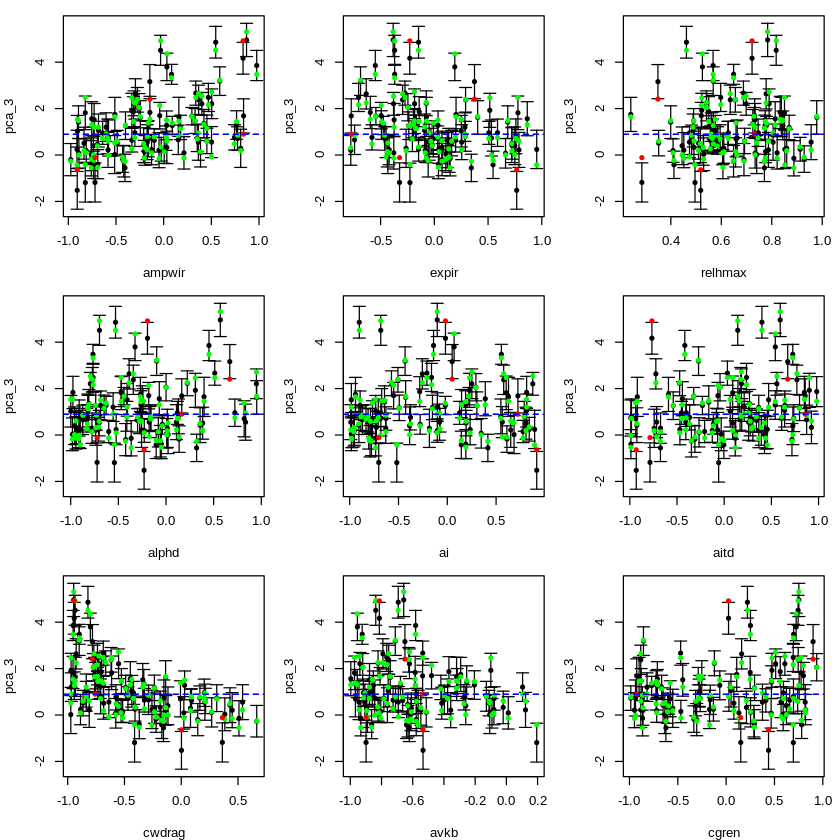

[[1]]
[1] 86

[[2]]
[1] 90

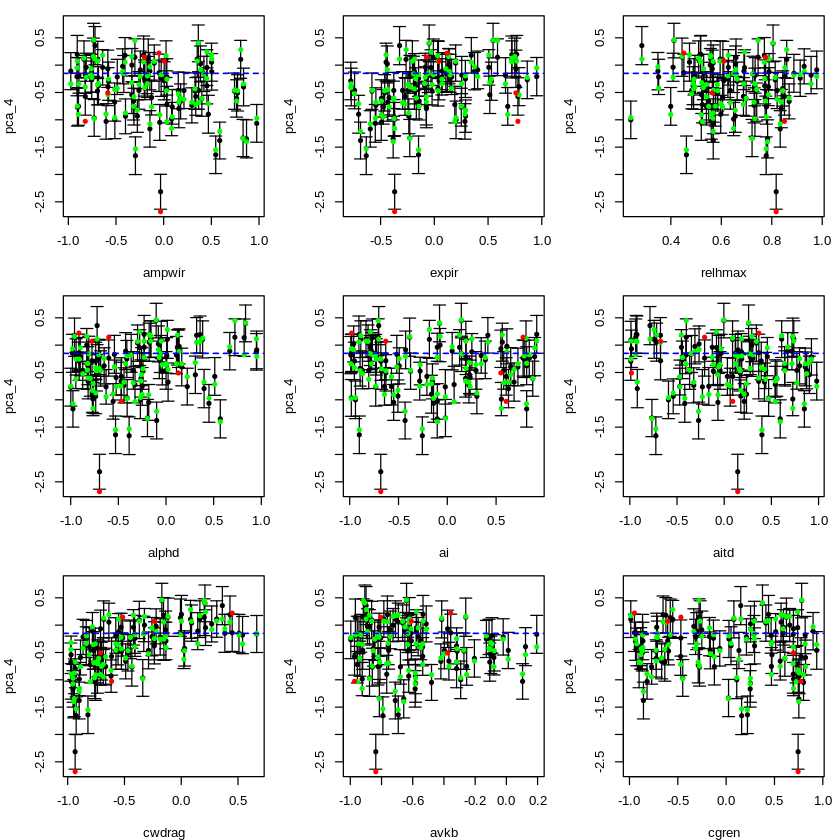

In [84]:
wave <- wave_steps_3_4(2,Design_points,list(),tImps, NROY1)
Nb_sim_list <- append(Nb_sim_list, nrow(Design_points))
Nb_sim_list

In [85]:
Timps <- wave$timpsW
Imp_L <- wave$impW
Nroy <- wave$nroyW
nroy_list <- append(nroy_list, list(Nroy))
Em_list <- list(wave$emulatorW)

[1] 0.000805

[[1]]
[1] 0.018488

[[2]]
[1] 0.000805

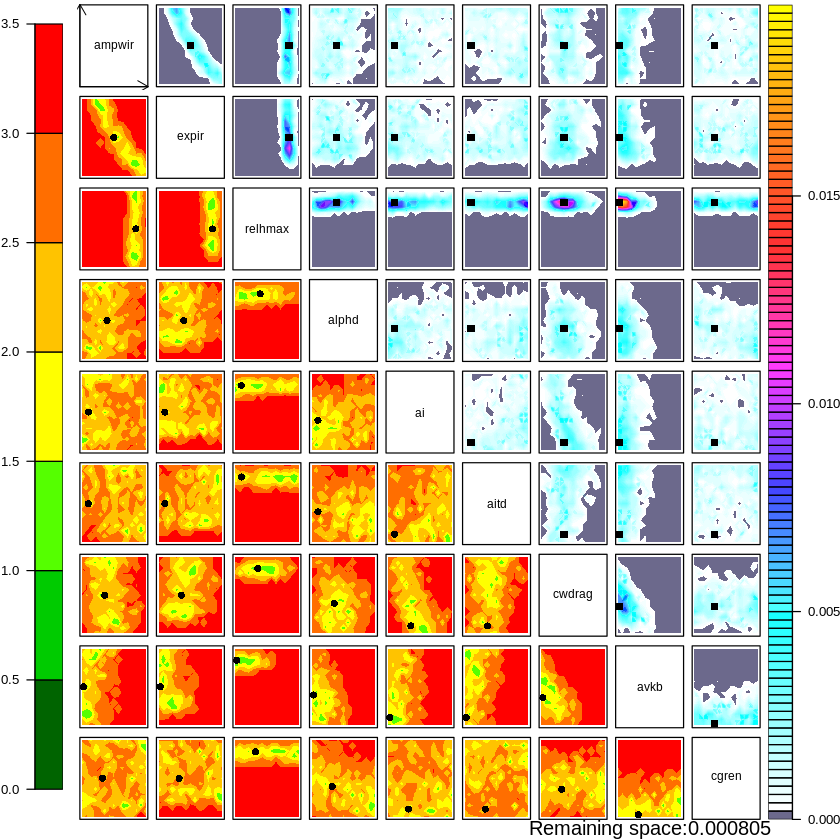

In [86]:
Ratio <- ratio(Nroy)
Ratio
ratio_list <- append(ratio_list, Ratio)
ratio_list
plot_NROY(Nroy, Imp_L)

And repeat for next waves...

# Wave 3 (for ATM-EVO_MEAN100L, ATM-EVO_MEAN100-20L experiments)

In [87]:
# step 1
set.seed(42)
Design_points <- wave_step_1(3,Em_list,Ratio,randomLHS)

[1] 90
[1] 179


**_Go to Python notebook for step 2_**

[1] "No fails"
[1] "Max reduction is 0.0239295305613058 using relhmax"
[1] "Max reduction is 0.0224077152278488 using expir"
[1] "Max reduction is 0.215702032791655 using ampwir"
[1] "Max reduction is 0.0605150945476458 using alphd"
[1] "Max reduction is 0.0252750667637571 using ai"
[1] "Max reduction is 0.0133556765164105 using cwdrag"
[1] "Max reduction is 0.0123900739444847 using cgren"
[1] "Max reduction is 0.0166220152925871 using expir"
[1] "Max reduction is 0.0119330845799427 using aitd"
[1] "Max reduction is 0.0150290057205183 using avkb"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = pca_0 ~ relhmax + expir + I(expir^2) + ampwir + 
    alphd + ai + cwdrag + cgren + aitd + avkb + I(expir * relhmax) + 
    I(ampwir * relhmax) + I(alphd * relhmax) + I(ai * relhmax) + 
    I(cwdrag * relhmax) + I(cgren * relhmax) + I(aitd * relhmax) + 
    I(avkb * relhmax) + I(ampwir * expir) + I(alphd * expir) + 
    I(ai * expir) + I(cwdrag * expir) + I(c

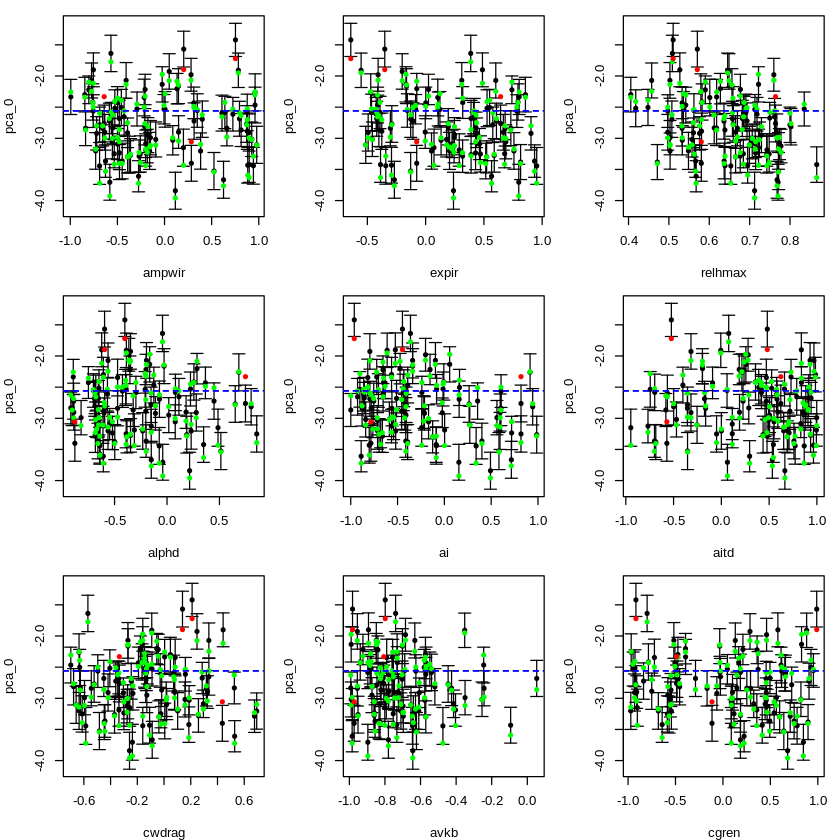

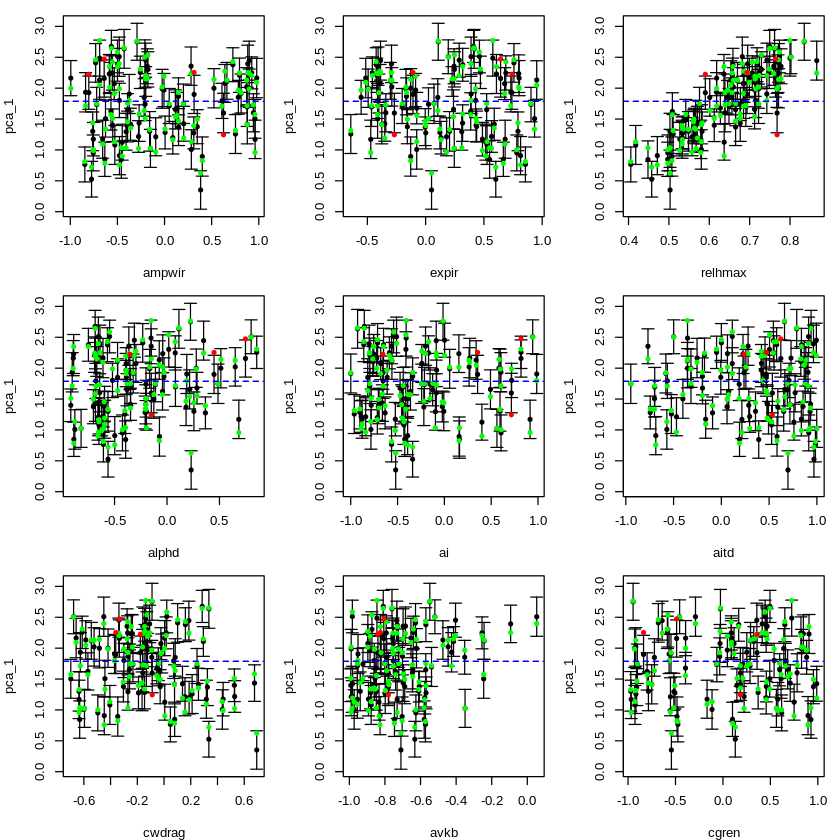

[[1]]
[1] 86

[[2]]
[1] 90

[[3]]
[1] 90

In [88]:
# steps 3-4
wave <- wave_steps_3_4(3,Design_points,Em_list,Timps, Nroy)
Nb_sim_list <- append(Nb_sim_list, nrow(Design_points))
Nb_sim_list

In [89]:
Timps <- wave$timpsW
Imp_L <- wave$impW
Nroy <- wave$nroyW
nroy_list <- append(nroy_list, list(Nroy))
Em_list <- append(Em_list,list(wave$emulatorW))

In [90]:
Ratio <- ratio(Nroy)
Ratio
ratio_list <- append(ratio_list, Ratio)
ratio_list
plot_NROY(Nroy, Imp_L)

[1] 4.4e-05

[[1]]
[1] 0.018488

[[2]]
[1] 0.000805

[[3]]
[1] 4.4e-05

# Selection of configurations

## I. K means 
The wave we perform the k-means on may change between the experiments. You change the entry for the key WAVE_K_MEANS in the parameters json file. 


In [29]:
wave_k_means = simu_param$WAVE_K_MEANS

In [30]:
preProcValues <- preProcess(Xp[nroy_list[[wave_k_means]],], method = c("center", "scale"))
normalizeddata <- predict(preProcValues, Xp[nroy_list[[wave_k_means]],])

In [31]:
# voir quel initializer prendre 
opt_km = Optimal_Clusters_KMeans(normalizeddata, criterion = "silhouette", max_clusters=10, plot_clusters = TRUE) #, initializer='quantile_init')

Warning: si le kmeans ne fonctionne pas avec l'erreur "Evaluation error: r > n and repeats.allowed=FALSE." , changer l'initializer pour 'quantile_init' 

In [32]:
opt_km

 [1] 0.0000000 0.1778074 0.1551408 0.1548759 0.1556721 0.1433862 0.1666520
 [8] 0.1394020 0.1383370 0.1625563
attr(,"class")
[1] "k-means clustering"

In [34]:
opt_centers = simu_param$OPT_CLUSTERS # best silhouette score, nb_clusters > 2. change according to the silhouette scores above -> put in parameters simu 

In [35]:
classif <- kmeans(normalizeddata, centers=opt_centers, iter.max=100, nstart=100)
kmcenters <- unPreProc(preProcValues, data.frame(classif$centers))
candidates <- rangeUnscale(kmcenters, my_bounds)
candidates


ampwir    expir     relhmax   alphd     ai       aitd     cwdrag     
1 0.7509983 0.4674473 0.8597770 0.7675079 533.2132 254.0367 0.001704594
2 1.2188904 0.3668652 0.8391520 0.7895519 373.5258 399.7592 0.002413453
3 1.3276278 0.3553418 0.8099264 0.7044905 272.5285 655.8470 0.002668996
4 1.2513666 0.3860293 0.8379275 0.7906909 274.1915 351.1653 0.002465579
5 0.7401652 0.5145903 0.8339835 0.7925702 316.3302 307.9126 0.002472190
6 0.7859947 0.5174372 0.8437784 0.7859306 278.1450 890.2066 0.002903327
7 1.2013289 0.3489711 0.8328114 0.6994331 384.6441 320.5129 0.001835090
  avkb         cgren     
1 1.445170e-05 0.04124207
2 1.524681e-05 0.02990031
3 1.851246e-05 0.07915435
4 2.613657e-05 0.03528613
5 1.598080e-05 0.05788042
6 1.771344e-05 0.07048533
7 1.557809e-05 0.08446713

### Ensemble of plausible simulations

In [36]:
### check if Kmeans centers are in NROY
em_nroy <- TestEm # for wave 1 
if (wave_k_means > 1){
    em_nroy <- Em_list[[wave_k_means-1]] # wave > 1 
}

imps_kmeans <- ImplausibilityMOGP(NewData=kmcenters, Emulator=em_nroy, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
which(rowSums(imps_kmeans <= cutoff_vec[1]) >= em_nroy$mogp$n_emulators -valmax)

[1] 1 2 3 4 5 7

In [37]:
testpoints <- rangeUnscale(kmcenters, my_bounds)[rowSums(imps_kmeans <= cutoff_vec[1]) >= em_nroy$mogp$n_emulators -valmax,]
write.csv(testpoints,str_glue("DATA/{EXP}/candidates_wave_{wave_k_means}.csv"), row.names = FALSE)
testpoints

ampwir    expir     relhmax   alphd     ai       aitd     cwdrag     
1 0.7509983 0.4674473 0.8597770 0.7675079 533.2132 254.0367 0.001704594
2 1.2188904 0.3668652 0.8391520 0.7895519 373.5258 399.7592 0.002413453
3 1.3276278 0.3553418 0.8099264 0.7044905 272.5285 655.8470 0.002668996
4 1.2513666 0.3860293 0.8379275 0.7906909 274.1915 351.1653 0.002465579
5 0.7401652 0.5145903 0.8339835 0.7925702 316.3302 307.9126 0.002472190
7 1.2013289 0.3489711 0.8328114 0.6994331 384.6441 320.5129 0.001835090
  avkb         cgren     
1 1.445170e-05 0.04124207
2 1.524681e-05 0.02990031
3 1.851246e-05 0.07915435
4 2.613657e-05 0.03528613
5 1.598080e-05 0.05788042
7 1.557809e-05 0.08446713

## II. Candidates without preprocessing 
Sometimes the NROY is so reduced that we can directly take the last members as direct candidates to test. _wave_candidate_ is 0 when we don't want to do this process.

In [60]:
wave_candidate = simu_param$WAVE_CANDIDATE
wave_candidate

[1] 0

In [61]:
if (wave_candidate > 0){ 
    direct_candidate <- rangeUnscale(Xp[nroy_list[[wave_candidate]],], my_bounds)
    write.csv(direct_candidate, str_glue("DATA/{EXP}/direct_candidates_wave_{wave_candidate}.csv"), row.names = FALSE)
    direct_candidate
}

# Summary of the HM

In [51]:
ratio_vec <- unlist(ratio_list)

In [54]:
NROYs <- 100 * ratio_vec
NbSim <- Nb_sim_list 
LHS <- c('maximin', 'random') # to adapt depending the experiment 

In [55]:
data.frame(NROYs, NbSim, LHS)

NROYs  X90L X90L.1 LHS    
1 0.0307 90   90     maximin
2 0.0003 90   90     random

# _Go to the "Effective tuning" notebook to see the performances of these candidates._